In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import random
import gym
import numpy as np
from collections import deque
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, LSTM, Reshape, Dropout, Conv2D, Flatten
from keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:

def CartPole(input_shape, action_space):
    X_input = Input(input_shape)
    X = X_input

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu")(X)
    X = Dropout(0.5)(X)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu")(X)
    X = Dropout(0.5)(X)

    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu")(X)
    X = Dropout(0.5)(X)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear")(X)

    model = Model(inputs = X_input, outputs = X, name='CartPole_model')
    model.compile(loss='mse', optimizer=Adam())

    return model


In [4]:

class DQNAgent:
    def __init__(self):
        self.env = gym.make('CartPole-v1',render_mode='human')
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 150
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 128
        self.train_start = 1000

        self.model = CartPole(input_shape=(self.state_size,), action_space = self.action_size)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        target = self.model.predict(state)
        target_next = self.model.predict(next_state)

        for i in range(self.batch_size):

            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    def run(self):
        rewards=[]
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100

                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    print("episode: {}/{}, score: {}, e: {:.2}".format(e, self.EPISODES, i, self.epsilon))
                    if e == 149:
                        self.save("cartpole-dqn.keras")
                    break

                self.replay()
            rewards.append(i)

        plt.plot([i for i in range(150)], rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Training Reward per episode')
        plt.show()

    def test(self):
        self.load("cartpole-dqn.keras")
        rewards=[]
        for e in range(150):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)

                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))
                    break
            rewards.append(i)
        plt.plot([i for i in range(150)], rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title("Testing model")
        plt.show()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Streaming output truncated to the last 5000 lines.
episode: 131/150, score: 60, e: 0.001
1/1 [==============================] - 0s 32ms/step
episode: 132/150, score: 89, e: 0.001
1/1 [==============================] - 0s 27ms/step
episode: 133/150, score: 97, e: 0.001
1/1 [==============================] - 0s 30ms/step
episode: 134/150, score: 98, e: 0.001
1/1 [==============================] - 0s 30ms/step
episode: 135/150, score: 104, e: 0.001
1/1 [==============================] - 0s 35ms/step
episode: 136/150, score: 91, e: 0.001
1/1 [==============================] - 0s 38ms/step
episode: 137/150, score: 95, e: 0.001
1/1 [==============================] - 0s 28ms/step
episode: 138/150, score: 97, e: 0.001
1/1 [==============================] - 0s 25ms/step
episode: 139/150, score: 95, e: 0.001
1/1 [==============================] - 0s 32ms/step
episode: 140/150, score: 100, e: 0.001
1/1 [==============================] - 0s 31ms/step
episode: 141/150, score: 102, e: 0.001
1/1 [===

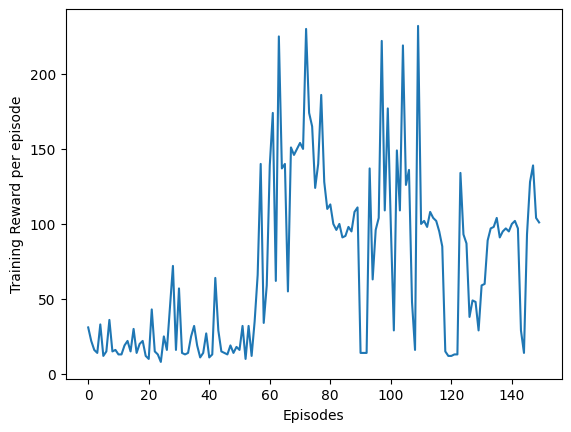

In [5]:
agent=DQNAgent()
agent.run()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 37ms/step
episode: 100/150, score: 106
1/1 [==============================] - 0s 29ms/step
episode: 101/150, score: 101
1/1 [==============================] - 0s 60ms/step
episode: 102/150, score: 99
1/1 [==============================] - 0s 59ms/step
episode: 103/150, score: 96
1/1 [==============================] - 0s 61ms/step
episode: 104/150, score: 95
1/1 [==============================] - 0s 27ms/step
episode: 105/150, score: 99
1/1 [==============================] - 0s 26ms/step
episode: 106/150, score: 98
1/1 [==============================] - 0s 35ms/step
episode: 107/150, score: 102
1/1 [==============================] - 0s 34ms/step
episode: 108/150, score: 101
1/1 [==============================] - 0s 41ms/step
episode: 109/150, score: 101
1/1 [==============================] - 0s 37ms/step
episode: 110/150, score: 103
1/1 [==============================] - 0s 32ms/step
episode: 11

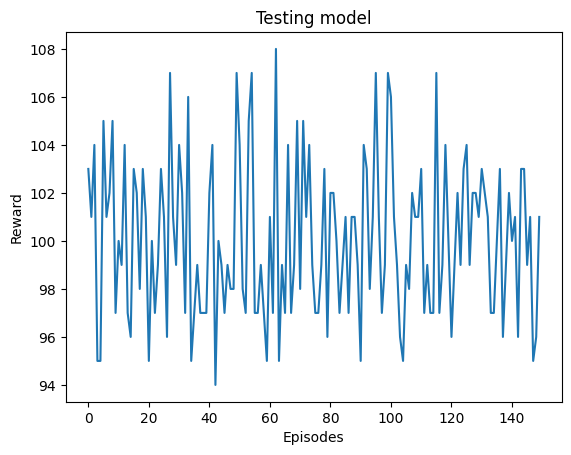

In [6]:
agent.test()